<a href="https://colab.research.google.com/github/ricky-kiva/dl-deep-tf-cnn/blob/main/3_a1_transfer_learn_horse_human.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Transfer Learning using Horse vs Human Dataset**

Download dataset

In [1]:
# Get the Horse or Human training dataset
!wget -q -P /content/ https://storage.googleapis.com/tensorflow-1-public/course2/week3/horse-or-human.zip

# Get the Horse or Human validation dataset
!wget -q -P /content/ https://storage.googleapis.com/tensorflow-1-public/course2/week3/validation-horse-or-human.zip

Unzip dataset

In [3]:
import zipfile

test_local_zip = './horse-or-human.zip'
zip_ref = zipfile.ZipFile(test_local_zip, 'r')
zip_ref.extractall('/tmp/training')

val_local_zip = './validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(val_local_zip, 'r')
zip_ref.extractall('/tmp/validation')

zip_ref.close()

Referencing directories

In [6]:
import os

train_dir = '/tmp/training'
validation_dir = '/tmp/validation'

train_horses_dir = os.path.join(train_dir, 'horses')
train_humans_dir = os.path.join(train_dir, 'humans')

validation_horses_dir = os.path.join(validation_dir, 'horses')
validation_humans_dir = os.path.join(validation_dir, 'humans')

Data exploration: number of samples

In [7]:
print(f"There are {len(os.listdir(train_horses_dir))} images of horses for training.\n")
print(f"There are {len(os.listdir(train_humans_dir))} images of humans for training.\n")

print(f"There are {len(os.listdir(validation_horses_dir))} images of horses for validation.\n")
print(f"There are {len(os.listdir(validation_humans_dir))} images of humans for validation.\n")

There are 500 images of horses for training.

There are 527 images of humans for training.

There are 128 images of horses for validation.

There are 128 images of humans for validation.



Data exploration: sample visualization

Sample horse image:


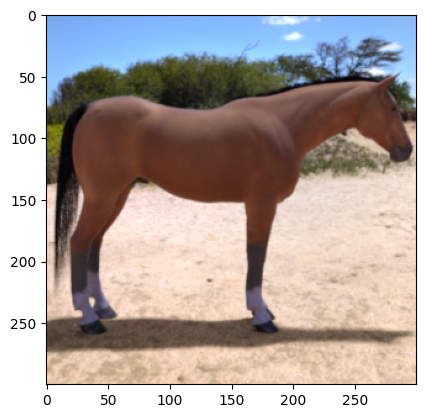


Sample human image:


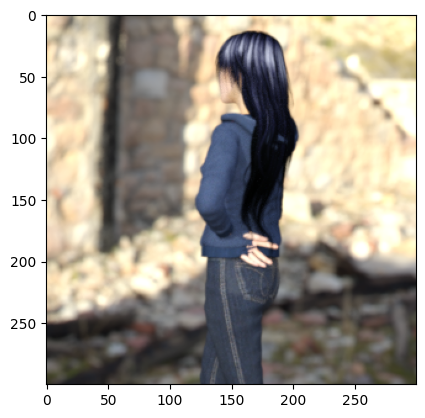

In [10]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img

print("Sample horse image:")
plt.imshow(load_img(f"{os.path.join(train_horses_dir, os.listdir(train_horses_dir)[0])}"))
plt.show()

print("\nSample human image:")
plt.imshow(load_img(f"{os.path.join(train_humans_dir, os.listdir(train_humans_dir)[0])}"))
plt.show()

Data exploration: check sample shape

In [12]:
from tensorflow.keras.utils import img_to_array

sample_image  = load_img(f"{os.path.join(train_horses_dir, os.listdir(train_horses_dir)[0])}")

sample_array = img_to_array(sample_image)

print(f"Each image has shape: {sample_array.shape}")

Each image has shape: (300, 300, 3)


Make function to generate generators

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def train_val_generators(TRAINING_DIR, VALIDATION_DIR):

  train_datagen = ImageDataGenerator(rescale=1./255.,
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')

  validation_datagen = ImageDataGenerator(rescale=1./255.)

  train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                      batch_size=32,
                                                      class_mode='binary',
                                                      target_size=(150, 150))

  validation_generator = validation_datagen.flow_from_directory(directory=validation_dir,
                                                                batch_size=32,
                                                                class_mode='binary',
                                                                target_size=(150, 150))

  return train_generator, validation_generator

Instantiate the generator

In [14]:
train_generator, validation_generator = train_val_generators(train_dir, validation_dir)

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


Download *custom weights* for `InceptionV3`

In [15]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2023-09-24 16:51:34--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.16.207, 142.251.167.207, 172.253.62.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.16.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   152MB/s    in 0.6s    

2023-09-24 16:51:35 (152 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



Referencing downloaded local weights file

In [17]:
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

Make function to create pre-trained model

In [16]:
def create_pre_trained_model(local_weights_file):

  pre_trained_model = InceptionV3(input_shape = (150, 150, 3),
                                  include_top = False,
                                  weights = None)

  pre_trained_model.load_weights(local_weights_file)

  for layer in pre_trained_model.layers:
    layer.trainable = False

  return pre_trained_model

Instantiate the pre-trained model

In [18]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

pre_trained_model = create_pre_trained_model(local_weights_file)
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 74, 74, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 74, 74, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 74, 74, 32)           0         ['batch_normalizati

Check parameters of the model

In [19]:
total_params = pre_trained_model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in pre_trained_model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 21,802,784 total parameters in this model.
There are 0 trainable parameters in this model.


Create callbacks

In [22]:
import tensorflow as tf

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.999):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

Create function to get last output of the pre-trained model

In [23]:
def output_of_last_layer(pre_trained_model):
  last_desired_layer = pre_trained_model.get_layer('mixed7')
  print('last layer output shape: ', last_desired_layer.output_shape)

  last_output = last_desired_layer.output
  print('last layer output: ', last_output)

  return last_output

Referencing output of pre-trained model

In [24]:
last_output = output_of_last_layer(pre_trained_model)

last layer output shape:  (None, 7, 7, 768)
last layer output:  KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 768), dtype=tf.float32, name=None), name='mixed7/concat:0', description="created by layer 'mixed7'")


Check pre-trained model type

In [25]:
print(f"The pretrained model has type: {type(pre_trained_model)}")

The pretrained model has type: <class 'keras.src.engine.functional.Functional'>


Seems like the model has been created using Tensorflow's [Functional API](https://www.tensorflow.org/guide/keras/functional)

Create function to make the model

In [29]:
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import RMSprop

def create_final_model(pre_trained_model, last_output):

  x = layers.Flatten()(last_output)
  x = layers.Dense(1024, activation='relu')(x)
  x = layers.Dropout(0.2)(x)
  x = layers.Dense(1, activation='sigmoid')(x)

  model = Model(inputs=pre_trained_model.input, outputs=x)

  model.compile(optimizer = RMSprop(learning_rate=0.0001),
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])

  return model

Instantiate the model

In [30]:
model = create_final_model(pre_trained_model, last_output)

Inspect the parameters of the final model

In [31]:
total_params = model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 47,512,481 total parameters in this model.
There are 38,537,217 trainable parameters in this model.


Train the model

In [32]:
callbacks = myCallback() # instantiate callback

history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = 100,
                    verbose = 2,
                    callbacks=callbacks)

Epoch 1/100
33/33 - 51s - loss: 0.2418 - accuracy: 0.9182 - val_loss: 0.0255 - val_accuracy: 0.9883 - 51s/epoch - 2s/step
Epoch 2/100
33/33 - 44s - loss: 0.0289 - accuracy: 0.9922 - val_loss: 0.0022 - val_accuracy: 1.0000 - 44s/epoch - 1s/step
Epoch 3/100
33/33 - 44s - loss: 0.0218 - accuracy: 0.9922 - val_loss: 0.0580 - val_accuracy: 0.9766 - 44s/epoch - 1s/step
Epoch 4/100
33/33 - 44s - loss: 0.0157 - accuracy: 0.9951 - val_loss: 0.0155 - val_accuracy: 0.9922 - 44s/epoch - 1s/step
Epoch 5/100
33/33 - 48s - loss: 0.0114 - accuracy: 0.9961 - val_loss: 0.0023 - val_accuracy: 1.0000 - 48s/epoch - 1s/step
Epoch 6/100

Reached 99.9% accuracy so cancelling training!
33/33 - 48s - loss: 0.0075 - accuracy: 0.9990 - val_loss: 0.0203 - val_accuracy: 0.9922 - 48s/epoch - 1s/step


Evaluate the results

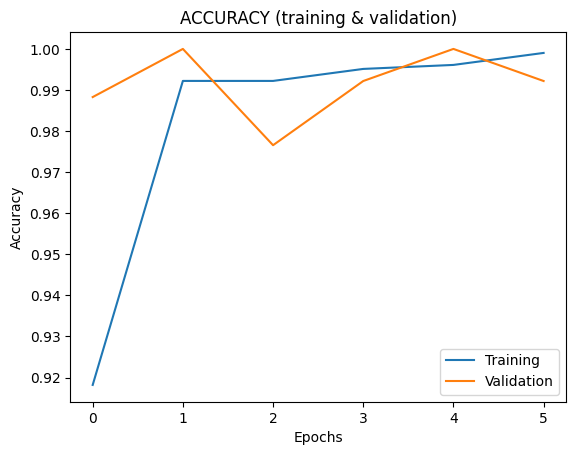

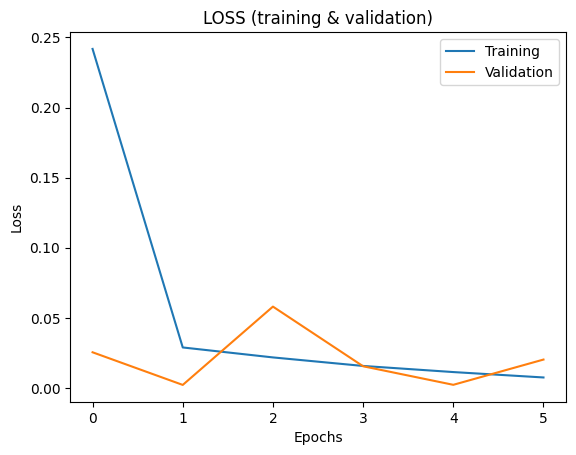

In [33]:
import matplotlib.pyplot as plt

# get data from history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# get epochs data
epochs = range(len(acc))

# plot accuracy data
plt.plot(epochs, acc, label='Training')
plt.plot(epochs, val_acc, label='Validation')
plt.title('ACCURACY (training & validation)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# plot loss data
plt.figure()
plt.plot(epochs, loss, label='Training')
plt.plot(epochs, val_loss, label='Validation')
plt.title('LOSS (training & validation)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()